# Personal Information
Name: **Wouter Knibbe**

StudentID: **12795526**

Email: [**wouter.knibbe@student.uva.nl**](wouter.knibbe@student.uva.nl)

Github **https://github.com/WouterKnibbe/ATSP_hillForHard**

Submitted on: **05.03.2024**

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import algorithm

In [2]:
def mutate_matrix(_matrix, _upper, _print):
    matrix = _matrix.copy()
    number1, number2 = 0, 0

    while number1 == number2:
        number1, number2 = np.random.randint(0,matrix.shape[0]), np.random.randint(0,matrix.shape[0])
    previous_number = matrix[number1,number2]
    while matrix[number1,number2] == previous_number:
        matrix[number1,number2] = np.random.randint(1,_upper)
    if _print:
        print(_matrix[number1,number2].round(1), "at", (number1,number2), "becomes", matrix[number1,number2].round(1))

    return matrix

In [6]:
def custom_encoder(obj):
    """
    Custom JSON encoder function that converts non-serializable objects.
    Converts:
    - numpy arrays to lists
    - numpy int64 to int
    - numpy float64 to float
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.inf):
        return "np.inf"
    else:
        # This will raise a TypeError for unknown types
        raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")

def save_merged(results, citysize, range):

    x = 0
    while True:
        file_path = f"Results/results{citysize}_{range}_merged.json"
        if not os.path.exists(file_path):
            break
        x += 1

    # Dumping the nested_dict to a json file with custom encoding
    with open(file_path, "w") as json_file:
        json.dump(results, json_file, default=custom_encoder)

    print(f"Results saved to JSON file successfully as {file_path}")

In [4]:
def custom_decoder(obj):
    """
    Custom decoder function that converts specific JSON values back to their original types.
    Converts:
    - 'Infinity' to np.inf
    """
    if isinstance(obj, dict):
        for key, value in obj.items():
            if value == "Infinity":
                obj[key] = np.inf
            # elif isinstance(value, list):
                # Convert lists back to arrays
                # obj[key] = np.array(value)
            elif isinstance(value, dict):
                obj[key] = custom_decoder(value)
    elif isinstance(obj, list):
        for i, value in enumerate(obj):
            if value == "Infinity":
                obj[i] = np.inf
            # elif isinstance(value, list):
                # obj[i] = np.array(value)
            elif isinstance(value, dict):
                obj[i] = custom_decoder(value)
    return obj

def load_result(file_path):

  # Loading the JSON file with custom decoding
  with open(file_path, "r") as json_file:
      loaded_results = json.load(json_file, object_hook=custom_decoder)

  return loaded_results

### Combine files

In [7]:
import re

cities = [30]
ranges = [1000]

for city in cities:
    for range_val in ranges:
        # Construct the directory path
        directory_path = f"Results"
        
        # Get all files in the directory
        files = os.listdir(directory_path)
        
        # Filter files based on the pattern: results{city}_{range}_x.json where x is any number
        pattern = re.compile(rf'^results{city}_{range_val}_\d+\.json$')
        json_files = [file for file in files if pattern.match(file)]

        # Proceed if there are any matching files
        if json_files:
            # Sort files to maintain order, assuming numeric sorting is desired
            json_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

            # Load the initial dictionary from the first file
            base_dict = load_result(os.path.join(directory_path, json_files[0]))
            last_key = max([int(k) for k in base_dict.keys()], default=0)

            # Merge the remaining dictionaries
            for file in json_files[1:]:  # Skip the first file as it's already loaded
                current_dict = load_result(os.path.join(directory_path, file))
                adjusted_dict = {str(int(key) + last_key): value for key, value in current_dict.items()}
                base_dict.update(adjusted_dict)
                last_key = max([int(k) for k in base_dict.keys()])

            # Save the merged dictionary
            save_merged(base_dict, city, range_val)


Results saved to JSON file successfully as Results/results30_1000_merged.json


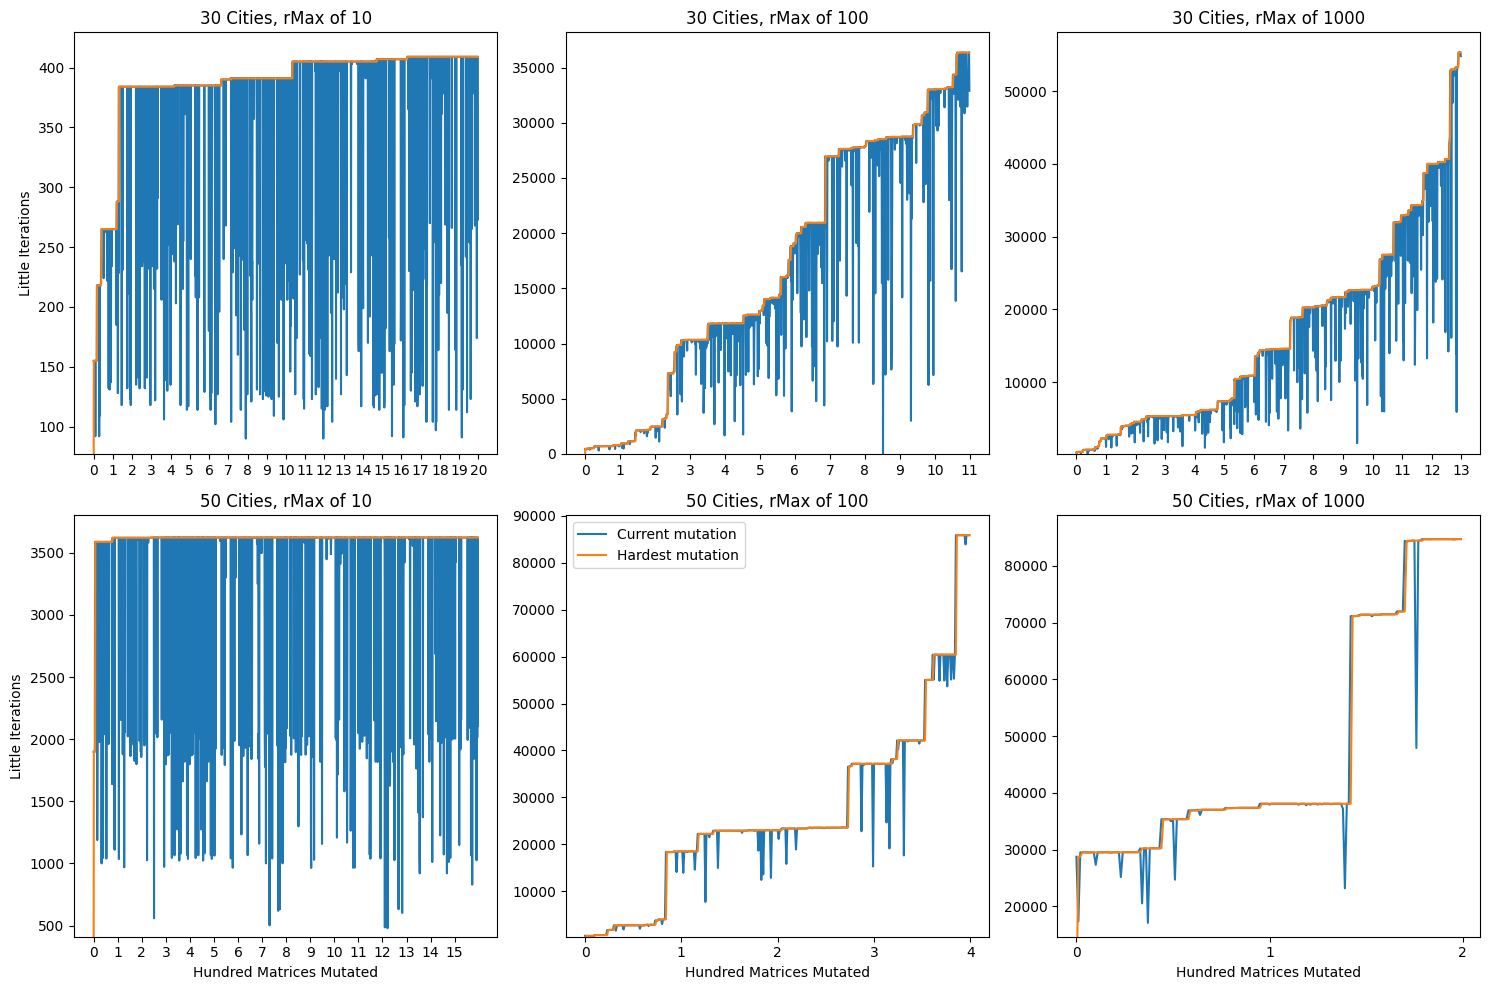

In [35]:
cities = [30, 50]
ranges = [10, 100, 1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 10)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        try:
           loaded = load_result(path)
        except:
           continue
        
        x_values = list(loaded.keys())
        y_values_0 = [values[0] for values in loaded.values()]  
        y_values_1 = [values[1] for values in loaded.values()] 
        
        if subplot_rows == 1 and subplot_cols == 1:
            ax = axs
            ax.set_xlabel('Matrices Mutated')
        else:
            if subplot_rows > 1 and subplot_cols > 1:
                ax = axs[i, j]
            elif subplot_rows > 1:
                ax = axs[i]
            else:
                ax = axs[j]

        ax.plot(x_values, y_values_0, label='Current mutation')
        ax.plot(x_values, y_values_1, label='Hardest mutation')

        xticklist = list(range(0,int(x_values[-1])+3,100))
        ax.set_xticks(xticklist)
        xticklabellist = list(range(0,int(x_values[-1])+3,100))
        ax.set_xticklabels(round(x/100) for x in xticklabellist)

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if j == 0:
          ax.set_ylabel('Little Iterations')
        if i == 1:
            ax.set_xlabel('Hundred Matrices Mutated')
        ax.set_title(f'{city} Cities, rMax of {range_val}')
        if i == 1 & j== 1:
          ax.legend()

plt.tight_layout()
plt.show()

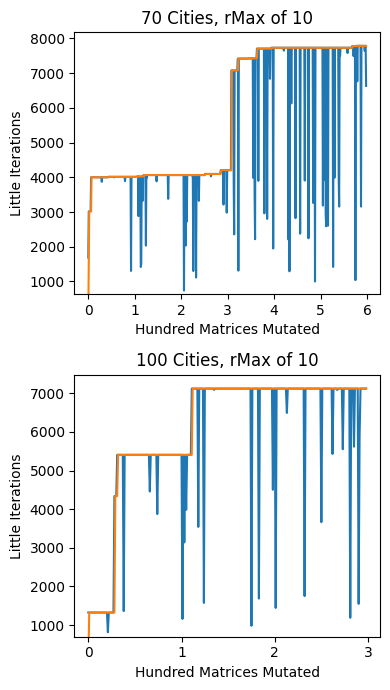

In [34]:
cities = [70, 100]
ranges = [10]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(4, 7)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        try:
           loaded = load_result(path)
        except:
           continue
        
        x_values = list(loaded.keys())
        y_values_0 = [values[0] for values in loaded.values()]  
        y_values_1 = [values[1] for values in loaded.values()] 
        
        if subplot_rows == 1 and subplot_cols == 1:
            ax = axs
            ax.set_xlabel('Matrices Mutated')
        else:
            if subplot_rows > 1 and subplot_cols > 1:
                ax = axs[i, j]
            elif subplot_rows > 1:
                ax = axs[i]
            else:
                ax = axs[j]

        ax.plot(x_values, y_values_0, label='Current mutation')
        ax.plot(x_values, y_values_1, label='Hardest mutation')

        xticklist = list(range(0,int(x_values[-1])+3,100))
        ax.set_xticks(xticklist)
        xticklabellist = list(range(0,int(x_values[-1])+3,100))
        ax.set_xticklabels(round(x/100) for x in xticklabellist)

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if j == 0:
          ax.set_ylabel('Little Iterations')
        ax.set_xlabel('Hundred Matrices Mutated')
        ax.set_title(f'{city} Cities, rMax of {range_val}')
        if i == 1 & j== 1:
          ax.legend()

plt.tight_layout()
plt.show()

### Analysis 4: Characteristics on the data

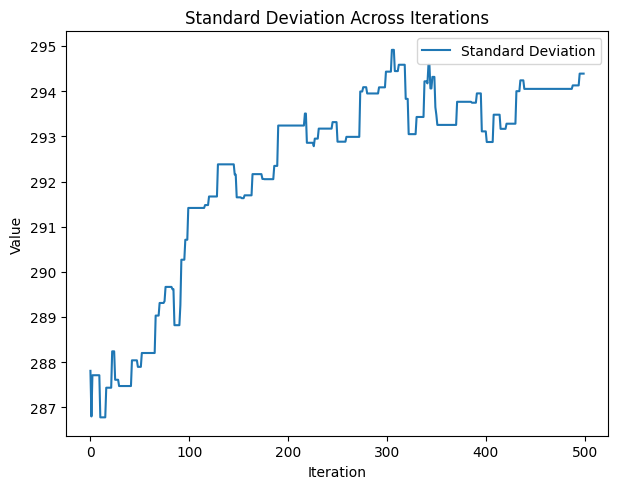

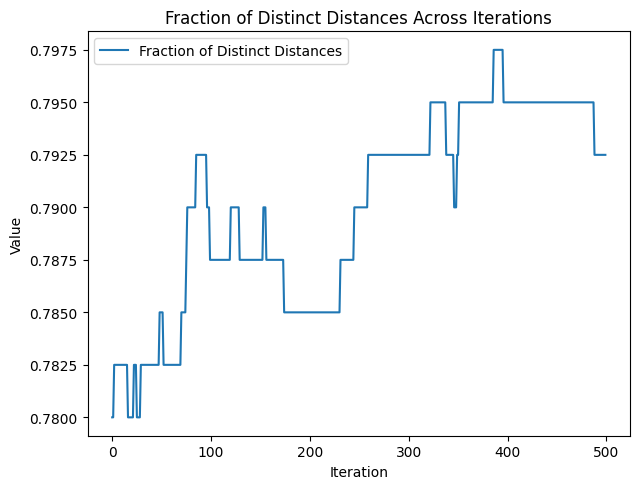

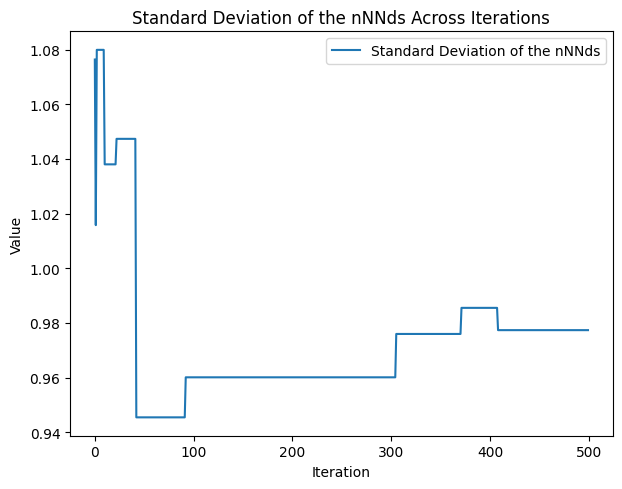

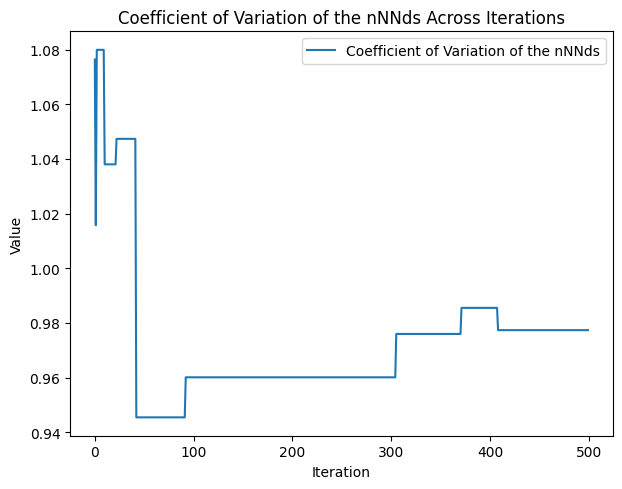

In [42]:
path = f"Results/results20_1000_0.json"
loaded = load_result(path)
l = []

hardest_matrices = []
for values in loaded.values():
    if values[0] > values[1]:
        hardest_matrices.append(values[4])
    else:
        hardest_matrices.append(hardest_matrices[-1])

for x in hardest_matrices:
    # Excluding infinite values for some calculations
    finite_distances = np.ma.masked_invalid(x)

    # 1. Standard Deviation (SD)
    sd = np.std(finite_distances)

    # 4. Fraction of Distinct Distances
    unique_distances = np.unique(finite_distances)
    fraction_distinct = unique_distances.size / finite_distances.size

    # 6. Standard Deviation of the Normalized Nearest-Neighbour Distances (nNNd)
    nearest = np.min(x, axis=1)
    mean_nearest = np.mean(nearest)
    normalized_nNNd = nearest / mean_nearest
    sd_nNNd = np.std(normalized_nNNd)

    # 7. Coefficient of Variation of the nNNds
    cv_nNNd = sd_nNNd / np.mean(normalized_nNNd)

    l.append([sd, fraction_distinct, sd_nNNd, cv_nNNd])

data = np.array(l)
for i, x in enumerate(['Standard Deviation', 'Fraction of Distinct Distances', 
                        'Standard Deviation of the nNNds',
                        'Coefficient of Variation of the nNNds']):
    plt.figure(figsize=(7, 5.25))
    plt.plot(data[:, i], label=x)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{x} Across Iterations')
    plt.legend()
    plt.show()

#### Standard deviation

20 cities, between 1 and 1000, pearson statistic: 0.704, Pvalue: 0.0
Pvalue rounded to 10 decimals


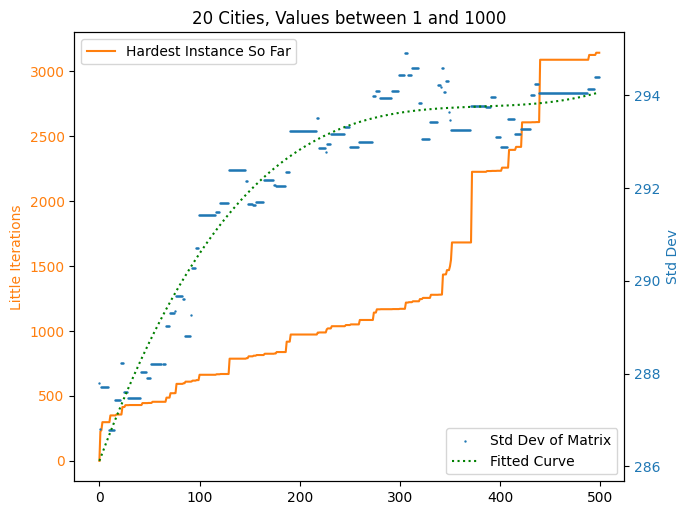

In [43]:
from scipy.stats import pearsonr

cities = [20]
ranges = [1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(7, 5.25)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)
        
        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])
        
        # these are just list comprehensions but instead of lists they are numpy arrays
        # numpy arrays make it easy to remove duplicates before we get to the correlation calculation
        y_values_std = np.fromiter((np.std(np.ma.masked_invalid(x)) for x in hardest_matrices), float)
        y_values = np.fromiter((values[1] for values in loaded.values()), float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_std, label='Std Dev of Matrix', color=color, s=0.5)
        ax2.set_ylabel('Std Dev', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_std, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')
        
        # remove duplicates before pearson correlation
        y_values_std = y_values_std[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_std, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_std, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")

plt.tight_layout()
plt.show()

#### Fraction of Distinct Distances

20 cities, between 1 and 1000, pearson statistic: 0.746, Pvalue: 0.0
Pvalue rounded to 10 decimals


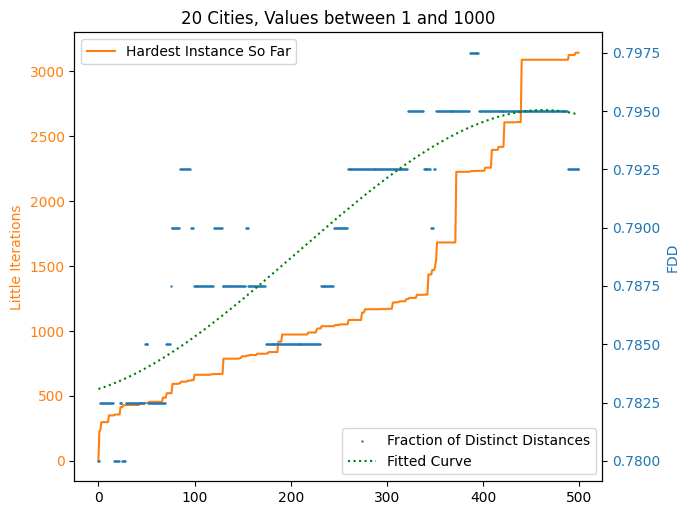

In [44]:
cities = [20]
ranges = [1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(7, 5.25)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])

        finite_distances = [np.ma.masked_invalid(x) for x in hardest_matrices]
        y_values_fdd = np.fromiter((np.unique(values).size / values.size for values in finite_distances),float)
        y_values = np.fromiter((values[1] for values in loaded.values()),float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_fdd, label='Fraction of Distinct Distances', color=color, s=0.5)
        ax2.set_ylabel('FDD', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        x_values = range(500)
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_fdd, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')

        y_values_fdd = y_values_fdd[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_fdd, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_fdd, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")
    
plt.tight_layout()
plt.show()

#### Std Dev of nNNds

20 cities, between 1 and 1000, pearson statistic: -0.137, Pvalue: 0.2452008422
Pvalue rounded to 10 decimals


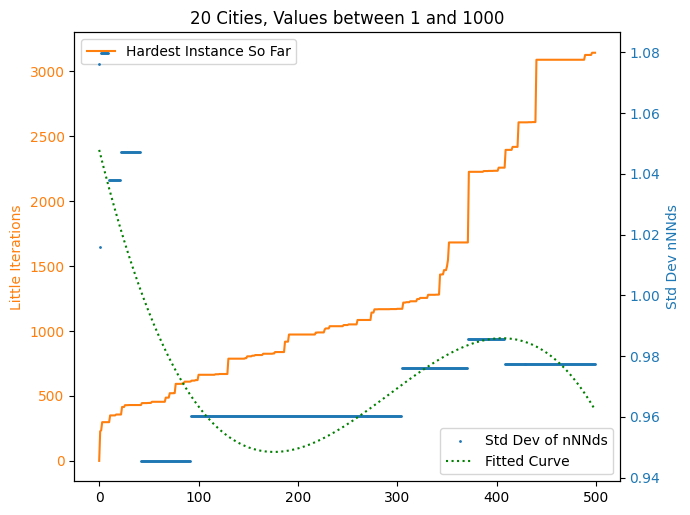

In [45]:
cities = [20]
ranges = [1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(7, 5.25)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])
        
        y_values_nearest = [np.min(x, axis=1) for x in hardest_matrices]
        y_values_mean_nearest = [np.mean(values) for values in y_values_nearest]
        # normalize distances and take std
        y_values_sd_nNNd = np.fromiter((np.std(x/y) for x,y in zip(y_values_nearest,y_values_mean_nearest)),float)

        y_values = np.fromiter((values[1] for values in loaded.values()),float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_sd_nNNd, label='Std Dev of nNNds', color=color, s=1)
        ax2.set_ylabel('Std Dev nNNds', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        x_values = range(500)
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_sd_nNNd, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')

        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'{city} Cities, Values between 1 and {range_val}')
        ax.legend()
        ax2.legend(loc='lower right')

        y_values_sd_nNNd = y_values_sd_nNNd[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_sd_nNNd, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_sd_nNNd, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")

plt.tight_layout()
plt.show()